In [36]:
import torch
from transformers import BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
from sklearn.model_selection import train_test_split
import torch.backends
import warnings
from datasets import Dataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("cvs_products.csv")

In [4]:
df.head()

,product,link,store,CVS,rating,review
0,辻利抹茶歐蕾 38,https://www.ptt.cc/bbs/CVS/M.1570449843.A.7FF....,全家,全家,30,難喝.. 喝起來沒有抹茶味 只有一股很噁的甜味和水味 為了確認又喝幾口 真的難喝 大家就避開...
1,香辣霸王雞球/原價39元（友善價28元）,https://www.ptt.cc/bbs/CVS/M.1570452664.A.B42....,全家,全家,60,基本上在便利商店買這個就是解嘴饞 （因為要吃的鹹酥雞都沒開...） 然後一如其它炸物 微波後...
2,黑松C&C氣泡飲(王林蘋果風味) / 原價$29 全家購入特價$22,https://www.ptt.cc/bbs/CVS/M.1570461438.A.947....,全家 / 黑松,全家,90,最近好多蘋果氣泡飲料喔 看到綠色瓶身很漂亮，又有嚐鮮價 立刻忍不住試試XD 和其他蘋果汽水比...
3,美少女戰士悠遊閃卡-戰士款/100元,https://www.ptt.cc/bbs/CVS/M.1570494716.A.C35....,7-11 / 悠遊卡股份有限公司,7-11,100,第一彈其實完全沒有follow到， 偶然在板上看到第二彈情報文，結果覺得更生火！ 身為兒時禮...
4,統一麵包紫薯QQ 35,https://www.ptt.cc/bbs/CVS/M.1570502732.A.406....,7-11 統一麵包,7-11,88,早上到小七挑早餐看到紫薯覺得很特別就買來吃吃看 麵包整個顏色偏紫 味道聞起來甜甜 有淡淡的紫...


In [5]:
df['rating'].unique()

array([ 30,  60,  90, 100,  88,  68,  95,  75,  85,  80,  70,  40,  98,
        86,  65,  79,  59,  39,  89,  55,  49,  66,  83,  92,  84,  58,
         3,  50,  87,  78,  15,  99,  61,  72,  20,  81,  82,  93,   0,
        73,  10,  56,   7,  96,  74,  67,   8,  63,  76,   1,  69,  45,
         5,  77,  33,  62,  48,  94,  19,  42,  35,  25,  29,  91,  23,
        11,  32,  64,  71,  43,  31,   2,  97,  28], dtype=int64)

In [56]:
rating_counts = df['rating'].value_counts().sort_values(ascending=False)
print(rating_counts.head(20))

80     1835
85     1459
90     1184
70      974
75      922
60      422
65      374
88      234
95      234
50      199
100     189
59      133
82      130
40      100
78       99
30       95
83       95
0        92
79       56
55       55
Name: rating, dtype: int64


In [6]:
average_ratings = df.groupby('CVS')['rating'].mean()

# 輸出結果
print(average_ratings)

CVS
7-11    75.067762
OK      74.958042
全家      76.982945
萊爾富     76.654160
Name: rating, dtype: float64


In [7]:
df.describe()

,rating
count,9618.000000
mean,76.253067
std,16.159308
min,0.000000
25%,70.000000
50%,80.000000
75%,85.000000
max,100.000000


In [8]:
df1 = df.drop(['product', 'store', 'link', 'CVS'], axis = 1)

In [13]:
df1.head()

,rating,review
0,30,難喝.. 喝起來沒有抹茶味 只有一股很噁的甜味和水味 為了確認又喝幾口 真的難喝 大家就避開...
1,60,基本上在便利商店買這個就是解嘴饞 （因為要吃的鹹酥雞都沒開...） 然後一如其它炸物 微波後...
2,90,最近好多蘋果氣泡飲料喔 看到綠色瓶身很漂亮，又有嚐鮮價 立刻忍不住試試XD 和其他蘋果汽水比...
3,100,第一彈其實完全沒有follow到， 偶然在板上看到第二彈情報文，結果覺得更生火！ 身為兒時禮...
4,88,早上到小七挑早餐看到紫薯覺得很特別就買來吃吃看 麵包整個顏色偏紫 味道聞起來甜甜 有淡淡的紫...


In [37]:
scaler = StandardScaler()
df1['rating_standard'] = scaler.fit_transform(df['rating'].values.reshape(-1, 1))

In [38]:
df1.head()

,rating,review,rating_standard
0,30,難喝.. 喝起來沒有抹茶味 只有一股很噁的甜味和水味 為了確認又喝幾口 真的難喝 大家就避開...,-2.862466
1,60,基本上在便利商店買這個就是解嘴饞 （因為要吃的鹹酥雞都沒開...） 然後一如其它炸物 微波後...,-1.005854
2,90,最近好多蘋果氣泡飲料喔 看到綠色瓶身很漂亮，又有嚐鮮價 立刻忍不住試試XD 和其他蘋果汽水比...,0.850757
3,100,第一彈其實完全沒有follow到， 偶然在板上看到第二彈情報文，結果覺得更生火！ 身為兒時禮...,1.469628
4,88,早上到小七挑早餐看到紫薯覺得很特別就買來吃吃看 麵包整個顏色偏紫 味道聞起來甜甜 有淡淡的紫...,0.726983


In [39]:
X_train, X_test, y_train, y_test = train_test_split(df1['review'], df1['rating_standard'], test_size=0.1, random_state=42)

In [10]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = AutoModelForSequenceClassification.from_pretrained(
    'ckiplab/albert-tiny-chinese-ws',
    num_labels=1,
    ignore_mismatched_sizes=True
)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ckiplab/albert-tiny-chinese-ws and are newly initialized: ['albert.pooler.bias', 'albert.pooler.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ckiplab/albert-tiny-chinese-ws and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 312]) in the checkpoint and torch.Size([1, 312]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model.config

AlbertConfig {
  "_name_or_path": "ckiplab/albert-tiny-chinese-ws",
  "architectures": [
    "AlbertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 101,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 102,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 312,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 1248,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 4,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertTokenizerFast",
  "transformers_version": "4.42.3",
  "type_vocab_size": 2,
  "vocab_size": 21128
}

In [12]:
model.classifier = torch.nn.Linear(model.config.hidden_size, 1)

In [12]:
# class PTTData(Dataset):
#     def __init__(self, X, Y, tokenizer, max_len = 512):
#         self.x = X
#         self.y = Y
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.x)
    
#     def __getitem__(self, idx):
#         x = self.x.iloc[idx]
#         y = self.y.iloc[idx]

#         encoding = self.tokenizer.encode_plus(
#             x, 
#             padding='max_length', 
#             max_length=self.max_len, 
#             truncation=True, 
#             return_tensors='pt'
#         )
        
#         input_ids = encoding['input_ids'].squeeze()
#         attention_mask = encoding['attention_mask'].squeeze()

#         # 检查输入的维度
#         print(input_ids.shape, attention_mask.shape)

#         return {
#             'input_ids': input_ids,
#             'attention_mask': attention_mask,
#             'label': torch.tensor(y, dtype=torch.float)
#         }
 
        

In [40]:
train_df = pd.DataFrame({'text': X_train, 'label': y_train.astype(float)})
test_df = pd.DataFrame({'text': X_test, 'label': y_test.astype(float)})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [41]:
train_df['label']

3956    1.160192
6352   -4.719078
2883   -1.005854
4509   -0.077549
711     0.417548
          ...   
5734   -1.005854
5191    0.850757
5390    1.036418
860     0.231887
7270    0.850757
Name: label, Length: 8656, dtype: float64

In [42]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/8656 [00:00<?, ? examples/s]

Map:   0%|          | 0/962 [00:00<?, ? examples/s]

In [43]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs', 
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    load_best_model_at_end=True
)

In [44]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [45]:
trainer.train()

  0%|          | 0/5410 [00:00<?, ?it/s]

{'loss': 642.2259, 'grad_norm': 1558.442138671875, 'learning_rate': 1e-05, 'epoch': 0.18}
{'loss': 2.5234, 'grad_norm': 12.049978256225586, 'learning_rate': 2e-05, 'epoch': 0.37}
{'loss': 1.2878, 'grad_norm': 31.094709396362305, 'learning_rate': 3e-05, 'epoch': 0.55}
{'loss': 1.2702, 'grad_norm': 283.6398620605469, 'learning_rate': 4e-05, 'epoch': 0.74}
{'loss': 1.1096, 'grad_norm': 21.44092559814453, 'learning_rate': 5e-05, 'epoch': 0.92}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 1.3721643686294556, 'eval_runtime': 10.384, 'eval_samples_per_second': 92.642, 'eval_steps_per_second': 5.874, 'epoch': 1.0}
{'loss': 1.0478, 'grad_norm': 26.937990188598633, 'learning_rate': 4.89816700610998e-05, 'epoch': 1.11}
{'loss': 1.0277, 'grad_norm': 148.75587463378906, 'learning_rate': 4.79633401221996e-05, 'epoch': 1.29}
{'loss': 1.0407, 'grad_norm': 89.99839782714844, 'learning_rate': 4.694501018329939e-05, 'epoch': 1.48}
{'loss': 1.0624, 'grad_norm': 87.89129638671875, 'learning_rate': 4.592668024439919e-05, 'epoch': 1.66}
{'loss': 1.082, 'grad_norm': 75.37065124511719, 'learning_rate': 4.490835030549899e-05, 'epoch': 1.85}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 1.1064256429672241, 'eval_runtime': 10.343, 'eval_samples_per_second': 93.009, 'eval_steps_per_second': 5.898, 'epoch': 2.0}
{'loss': 0.9317, 'grad_norm': 34.96267318725586, 'learning_rate': 4.3890020366598776e-05, 'epoch': 2.03}
{'loss': 0.6866, 'grad_norm': 84.91112518310547, 'learning_rate': 4.287169042769857e-05, 'epoch': 2.22}
{'loss': 0.7692, 'grad_norm': 75.33419036865234, 'learning_rate': 4.185336048879837e-05, 'epoch': 2.4}
{'loss': 0.7399, 'grad_norm': 15.617774963378906, 'learning_rate': 4.083503054989817e-05, 'epoch': 2.59}
{'loss': 0.7994, 'grad_norm': 23.839462280273438, 'learning_rate': 3.981670061099796e-05, 'epoch': 2.77}
{'loss': 0.8851, 'grad_norm': 20.97551727294922, 'learning_rate': 3.879837067209776e-05, 'epoch': 2.96}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 0.7584136724472046, 'eval_runtime': 10.3324, 'eval_samples_per_second': 93.106, 'eval_steps_per_second': 5.904, 'epoch': 3.0}
{'loss': 0.7304, 'grad_norm': 21.931194305419922, 'learning_rate': 3.778004073319756e-05, 'epoch': 3.14}
{'loss': 0.6167, 'grad_norm': 19.236820220947266, 'learning_rate': 3.676171079429735e-05, 'epoch': 3.33}
{'loss': 0.5685, 'grad_norm': 28.828174591064453, 'learning_rate': 3.574338085539715e-05, 'epoch': 3.51}
{'loss': 0.5232, 'grad_norm': 47.255088806152344, 'learning_rate': 3.472505091649695e-05, 'epoch': 3.7}
{'loss': 0.6247, 'grad_norm': 29.03937339782715, 'learning_rate': 3.370672097759674e-05, 'epoch': 3.88}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 0.7035555243492126, 'eval_runtime': 10.3456, 'eval_samples_per_second': 92.986, 'eval_steps_per_second': 5.896, 'epoch': 4.0}
{'loss': 0.4531, 'grad_norm': 24.594961166381836, 'learning_rate': 3.268839103869654e-05, 'epoch': 4.07}
{'loss': 0.4237, 'grad_norm': 35.28298568725586, 'learning_rate': 3.167006109979633e-05, 'epoch': 4.25}
{'loss': 0.3864, 'grad_norm': 18.990264892578125, 'learning_rate': 3.065173116089613e-05, 'epoch': 4.44}
{'loss': 0.3492, 'grad_norm': 34.4315071105957, 'learning_rate': 2.9633401221995927e-05, 'epoch': 4.62}
{'loss': 0.4154, 'grad_norm': 50.49412536621094, 'learning_rate': 2.8615071283095725e-05, 'epoch': 4.81}
{'loss': 0.3733, 'grad_norm': 10.11195182800293, 'learning_rate': 2.759674134419552e-05, 'epoch': 4.99}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 0.7135956883430481, 'eval_runtime': 10.2308, 'eval_samples_per_second': 94.03, 'eval_steps_per_second': 5.962, 'epoch': 5.0}
{'loss': 0.2362, 'grad_norm': 18.18777847290039, 'learning_rate': 2.6578411405295317e-05, 'epoch': 5.18}
{'loss': 0.2118, 'grad_norm': 42.46464920043945, 'learning_rate': 2.5560081466395115e-05, 'epoch': 5.36}
{'loss': 0.2099, 'grad_norm': 16.178770065307617, 'learning_rate': 2.454175152749491e-05, 'epoch': 5.55}
{'loss': 0.2321, 'grad_norm': 15.038445472717285, 'learning_rate': 2.3523421588594704e-05, 'epoch': 5.73}
{'loss': 0.2672, 'grad_norm': 61.39918899536133, 'learning_rate': 2.2505091649694502e-05, 'epoch': 5.91}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 0.688459038734436, 'eval_runtime': 10.2452, 'eval_samples_per_second': 93.897, 'eval_steps_per_second': 5.954, 'epoch': 6.0}
{'loss': 0.1554, 'grad_norm': 10.53122329711914, 'learning_rate': 2.1486761710794297e-05, 'epoch': 6.1}
{'loss': 0.1611, 'grad_norm': 11.638997077941895, 'learning_rate': 2.0468431771894095e-05, 'epoch': 6.28}
{'loss': 0.1907, 'grad_norm': 9.239984512329102, 'learning_rate': 1.9450101832993893e-05, 'epoch': 6.47}
{'loss': 0.1372, 'grad_norm': 43.03913116455078, 'learning_rate': 1.8431771894093687e-05, 'epoch': 6.65}
{'loss': 0.1345, 'grad_norm': 26.116607666015625, 'learning_rate': 1.741344195519348e-05, 'epoch': 6.84}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 0.7480412721633911, 'eval_runtime': 10.2495, 'eval_samples_per_second': 93.858, 'eval_steps_per_second': 5.952, 'epoch': 7.0}
{'loss': 0.1205, 'grad_norm': 12.522576332092285, 'learning_rate': 1.639511201629328e-05, 'epoch': 7.02}
{'loss': 0.09, 'grad_norm': 6.918332576751709, 'learning_rate': 1.5376782077393077e-05, 'epoch': 7.21}
{'loss': 0.091, 'grad_norm': 10.191756248474121, 'learning_rate': 1.4358452138492872e-05, 'epoch': 7.39}
{'loss': 0.0829, 'grad_norm': 20.507282257080078, 'learning_rate': 1.334012219959267e-05, 'epoch': 7.58}
{'loss': 0.0805, 'grad_norm': 9.436700820922852, 'learning_rate': 1.2321792260692464e-05, 'epoch': 7.76}
{'loss': 0.0779, 'grad_norm': 17.215713500976562, 'learning_rate': 1.1303462321792262e-05, 'epoch': 7.95}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 0.7254511713981628, 'eval_runtime': 10.8211, 'eval_samples_per_second': 88.9, 'eval_steps_per_second': 5.637, 'epoch': 8.0}
{'loss': 0.0581, 'grad_norm': 6.289877891540527, 'learning_rate': 1.0285132382892057e-05, 'epoch': 8.13}
{'loss': 0.0497, 'grad_norm': 7.017858028411865, 'learning_rate': 9.266802443991853e-06, 'epoch': 8.32}
{'loss': 0.054, 'grad_norm': 12.040273666381836, 'learning_rate': 8.248472505091651e-06, 'epoch': 8.5}
{'loss': 0.0476, 'grad_norm': 10.282316207885742, 'learning_rate': 7.230142566191446e-06, 'epoch': 8.69}
{'loss': 0.0481, 'grad_norm': 23.71063232421875, 'learning_rate': 6.211812627291243e-06, 'epoch': 8.87}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 0.7342021465301514, 'eval_runtime': 10.8341, 'eval_samples_per_second': 88.794, 'eval_steps_per_second': 5.63, 'epoch': 9.0}
{'loss': 0.0426, 'grad_norm': 5.722010135650635, 'learning_rate': 5.193482688391039e-06, 'epoch': 9.06}
{'loss': 0.0262, 'grad_norm': 5.641330242156982, 'learning_rate': 4.175152749490835e-06, 'epoch': 9.24}
{'loss': 0.0356, 'grad_norm': 5.461765766143799, 'learning_rate': 3.1568228105906318e-06, 'epoch': 9.43}
{'loss': 0.0279, 'grad_norm': 4.584555625915527, 'learning_rate': 2.1384928716904276e-06, 'epoch': 9.61}
{'loss': 0.0244, 'grad_norm': 8.97751235961914, 'learning_rate': 1.120162932790224e-06, 'epoch': 9.8}
{'loss': 0.0246, 'grad_norm': 5.923080921173096, 'learning_rate': 1.0183299389002036e-07, 'epoch': 9.98}


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 0.7300607562065125, 'eval_runtime': 10.3447, 'eval_samples_per_second': 92.994, 'eval_steps_per_second': 5.897, 'epoch': 10.0}
{'train_runtime': 2568.029, 'train_samples_per_second': 33.707, 'train_steps_per_second': 2.107, 'train_loss': 12.326706225296926, 'epoch': 10.0}


TrainOutput(global_step=5410, training_loss=12.326706225296926, metrics={'train_runtime': 2568.029, 'train_samples_per_second': 33.707, 'train_steps_per_second': 2.107, 'total_flos': 348519843594240.0, 'train_loss': 12.326706225296926, 'epoch': 10.0})

In [46]:
eval_results = trainer.evaluate()

print(f"Validation Loss: {eval_results['eval_loss']}")

  0%|          | 0/61 [00:00<?, ?it/s]

Validation Loss: 0.688459038734436


In [47]:
predictions, labels, _ = trainer.predict(test_dataset)

  0%|          | 0/61 [00:00<?, ?it/s]

In [48]:

mse = mean_squared_error(labels, predictions)

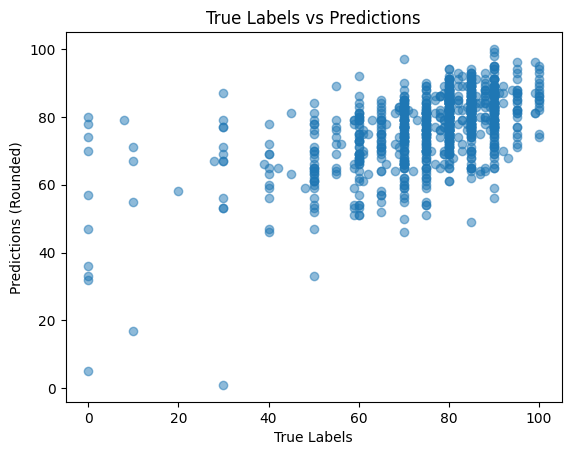

In [50]:

labels_original = scaler.inverse_transform(labels.flatten().reshape(-1, 1)).flatten()
predictions_original = scaler.inverse_transform(predictions.flatten().reshape(-1, 1)).flatten()
predictions_rounded = np.round(predictions_original)
plt.scatter(labels_original, predictions_rounded, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Predictions (Rounded)')
plt.title('True Labels vs Predictions')
plt.show()